Data


In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
    'Data/asl_alphabet_train/asl_alphabet_train',  
    target_size=(32, 32), 
    batch_size=32,  
    class_mode='categorical',  
    shuffle=True
)


Found 87000 images belonging to 29 classes.


In [4]:
test_generator = test_datagen.flow_from_directory(
    "Data/asl_alphabet_test/asl_alphabet_test",
    target_size=(32,32),
    batch_size=32,
    class_mode='categorical',  
    shuffle=False,
)

Found 29 images belonging to 29 classes.


In [5]:
x_train, t_train = next(train_generator)

In [6]:
x_test, t_test = next(test_generator)

In [14]:
# Initialize empty lists to store the data
x_train, t_train = [], []
x_test, t_test = [], []

# Load training data
for x_batch, t_batch in train_generator:
    x_train.append(x_batch)
    t_train.append(t_batch)
    if len(x_train) * train_generator.batch_size >= len(train_generator.classes):
        break  # Exit when we've seen all images

# Load testing data
for x_batch, t_batch in test_generator:
    x_test.append(x_batch)
    t_test.append(t_batch)
    if len(x_test) * test_generator.batch_size >= len(test_generator.classes):
        break  # Exit when we've seen all images

# Convert lists to numpy arrays
x_train = np.concatenate(x_train, axis=0)
t_train = np.concatenate(t_train, axis=0)
x_test = np.concatenate(x_test, axis=0)
t_test = np.concatenate(t_test, axis=0)

# Print the shape of the data to confirm
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)


(87000, 28, 28, 3) (87000, 29) (29, 32, 32, 3) (29, 29)


(29,)
float32
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]


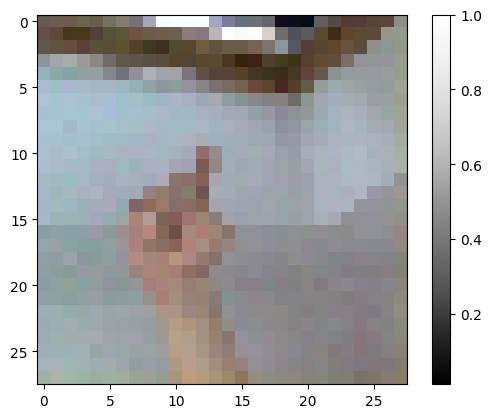

In [17]:
# mnist, fashion mnist
print(t_train[0].shape)
print(t_train[0].dtype)
print(t_train[0])

plt.imshow(x_train[0], cmap='Greys_r')
plt.colorbar()
plt.show()


In [ ]:
class Reservoir(object):
    def __init__(self,i_size,r_size,i_coef=1.0,r_coef=0.999,sparse=0.5,leak=0.5):
        self.w_i = i_coef * np.random.uniform(-1,1,(r_size,i_size)).astype(np.float32)
        self.w_r = np.random.uniform(-1,1,(r_size*r_size, )).astype(np.float32)
        np.random.shuffle(self.w_r)
        self.w_r = self.w_r.reshape(r_size,r_size)
        self.w_r = self.w_r/max(abs(np.linalg.eig(self.w_r)[0])) * r_coef
        self.w_r = np.array(self.w_r)

        self.leak = leak

    def reset(self,batch):
        self.x = np.zeros((batch,self.w_r.shape[0]),dtype=np.float32)


    def __call__(self,u):
        if not u.shape[0] == self.x.shape[0]:
            print("different batchsize")
            print("required:",self.x.shape[0])
            print("actual",u.shape[0])
        self.x = np.tanh((1-self.leak)*self.x+self.leak*(u.dot(self.w_i.T)+self.x.dot(self.w_r.T)),dtype=np.float32)
        return self.x
    
    def reset_and_call(self,us):
        self.reset(batch=us.shape[1])

        for u in us:
            x = self.__call__(u)
        return copy.deepcopy(x)


        

In [ ]:
class ReservoirBasedConvolution2D(object):
    def __init__(self,k_size,stride,padding,in_ch,num_reservoir,num_node,sparse,i_coef=1.0,r_coef=0.999):
        leaks = np.linspace(0.1,0.9,num_reservoir)
        self.res = [Reservoir(in_ch*k_size,num_node,sparse=sparse,leak=l,i_coef=i_coef,r_coef=r_coef) for l in leaks]
        self.k_size = k_size
        self.stride = stride
        self.padding = padding

    def __call__(self,x):
        aois_h,num_row_h,num_col_h = self._image2aoisH(x,self.k_size,self.stride,self.padding)
        aois_v,num_row_v,num_col_v = self._image2aoisV(x,self.k_size,self.stride,self.padding)
        hs_h = []
        for res in self.res:
            h = res.reset_and_call(aois_h)
            hs_h.append(h)

        #(B*N,C)->(N,B,C) = (H*W,B,C)
        hs_h = np.concatenate(hs_h,axis=1)
        hs_h = hs_h.reshape(num_row_h*num_col_h,-1,hs_h.shape[1])

        #conv 2 image: (H*W,B,C) -> (B,C,H*W)->(B,C,H,W)
        images_h = np.array(hs_h)
        images_h = np.rollaxis(images_h,0,3)
        images_h = images_h.reshape(images_h.shape[0],images_h.shape[1],num_row_h,num_col_h)

        hs_v = []
        for res in self.res:
            h = res.reset_and_call(aois_v)
            hs_v.append(h)
        
        # (B*N,C)->(N,B,C) = (H*W,B,C)
        hs_v = np.concatenate(hs_v,axis=1)
        hs_v = hs_v.reshape(num_row_v*num_col_v,-1,hs_v.shape[1])

        # convs 2 image: (H*W,B,C)
        images_v = np.asarray(hs_v)
        images_v = np.rollaxis(images_v, 0, 3)
        images_v = images_v.reshape(images_v.shape[0], images_v.shape[1], num_row_v, num_col_v)

        # (B, C, H, W) + (B, C, H, W) -> (B, 2C, H, W)
        images = np.concatenate([images_h, images_v], axis=1)
        return images
    
    def _image2aoisH(self, x, k_size, stride, padding):
        # x (B, C, H, W)

        # padding
        x_pad = np.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding, x.shape[3] + 2*padding), dtype=xp.float32)
        x_pad[:, :, padding:padding + x.shape[2], padding:padding + x.shape[3]] = x

        # areas of interest
        aois = []
        num_row = (x_pad.shape[2] - k_size) // stride + 1
        num_col = (x_pad.shape[3] - k_size) // stride + 1
        for h in range(0, x_pad.shape[2] - k_size + 1, stride):
            for w in range(0, x_pad.shape[3] - k_size + 1, stride):
                aoi = x_pad[:, :, h:h+k_size, w:w+k_size]

                # (B, C, H, W) -> (H, B, C, W) -> (H, B, C*W) = (T, B, C*W)
                aoi = np.rollaxis(aoi, 2, 0)
                aoi = aoi.reshape(aoi.shape[0], aoi.shape[1], -1)

                aois.append(aoi)

        # (T, B*N, C*W)
        aois = np.concatenate(aois, axis=1)
        return aois, num_row, num_col


    def _image2aoisV(self, x, k_size, stride, padding):
        # x (B, C, H, W)

        # padding
        x_pad = np.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding, x.shape[3] + 2*padding), dtype=xp.float32)
        x_pad[:, :, padding:padding + x.shape[2], padding:padding + x.shape[3]] = x

        # areas of interest
        aois = []
        num_row = (x_pad.shape[2] - k_size) // stride + 1
        num_col = (x_pad.shape[3] - k_size) // stride + 1
        for h in range(0, x_pad.shape[2] - k_size + 1, stride):
            for w in range(0, x_pad.shape[3] - k_size + 1, stride):
                aoi = x_pad[:, :, h:h+k_size, w:w+k_size]

                # (B, C, H, W) -> (W, B, C, H) -> (W, B, C*H) = (T, B, C*H)
                aoi = np.rollaxis(aoi, 3, 0)
                aoi = aoi.reshape(aoi.shape[0], aoi.shape[1], -1)

                aois.append(aoi)

        # (T, B*N, C*H)
        aois = np.concatenate(aois, axis=1)
        return aois, num_row, num_col

In [ ]:
def max_pool2d(x, k_size, stride, padding=0):
    # padding
    x_pad = np.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding, x.shape[3] + 2*padding), dtype=xp.float32)
    x_pad[:, :, padding:padding + x.shape[2], padding:padding + x.shape[3]] = x

    # aois
    aois = []
    num_row = (x_pad.shape[2] - k_size) // stride + 1
    num_col = (x_pad.shape[3] - k_size) // stride + 1
    for h in range(0, x_pad.shape[2] - k_size + 1, stride):
        for w in range(0, x_pad.shape[3] - k_size + 1, stride):
            aoi = x_pad[:, :, h:h+k_size, w:w+k_size]
            aoi = aoi.reshape(aoi.shape[0], aoi.shape[1], -1)
            aois.append(aoi)

    # pooling
    aois = np.array(aois)
    pools = np.max(aois, axis=3)

    # (H*W, B, C) -> (B, C, H*W)
    pools = np.array(pools)
    pools = np.rollaxis(pools, 0, 3)
    pools = pools.reshape(pools.shape[0], pools.shape[1], num_row, num_col)

    return pools

In [ ]:
def ridge_regression(x, t, norm=1.0):
    array = x.T.dot(x)
    array = array + norm * np.eye(x.shape[1])
    array = np.linalg.inv(array)
    array = array.dot(x.T)
    array = array.dot(t)

    return array.T

In [ ]:
conv1 = ReservoirBasedConvolution2D(k_size=3, stride=1, padding=0, in_ch=3, num_reservoir=5, num_node=12, sparse=0.5)
conv2 = ReservoirBasedConvolution2D(k_size=3, stride=1, padding=0, in_ch=120, num_reservoir=5, num_node=30, sparse=1.0)
w_o = np.zeros((10, 7501), dtype=np.float32)

In [ ]:
def forward(x):
    h = conv1(x)
    h = max_pool2d(h, k_size=2, stride=2)
    h = conv2(h)
    h = max_pool2d(h, k_size=2, stride=2)

    h = h.reshape(h.shape[0], -1)
    h_pad = np.ones((h.shape[0], h.shape[1] + 1), dtype=np.float32)
    h_pad[:, 0:-1] = h

    y = h_pad.dot(w_o.T)
    return y, h_pad